In [24]:
import os
from matplotlib import pyplot as plt
import cv2 as cv
from dataclasses import dataclass
import numpy as np
import tqdm.auto as tqdm

In [19]:
class ImageLoader:

    BACKGROUND_COLOR = np.array([0, 172, 194])
    EMPTY_TILE_COLOR = np.array([223, 247, 249])
    COLOR_TOLERANCE = np.array([10, 10, 10])

    @dataclass
    class ImageRawData:
        name: str
        puzzle_image: np.ndarray
        level_label: np.ndarray
        target_moves: np.ndarray
        
    @dataclass
    class ImageProcessed:
        size: int
        blocked_locations: list[tuple[int, int]]
        initial_locations: list[tuple[int, int]]
        target_locations: list[tuple[int, int]]

    def __init__(self):
        self.files = list(filter(lambda x: x.endswith('.jpg'), sorted(os.listdir())))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, image_id: int) -> ImageRawData:
        image = plt.imread(self.files[image_id])
        return self.ImageRawData(
            name=self.files[image_id],
            puzzle_image=image[665:1710, 15:-15],
            level_label=image[420:500, 25:500],
            target_moves=image[570:650, 600:1000],
        )

    @classmethod
    def parse_puzzle_image(cls, target_image: np.ndarray, multiple_colors: bool):
        boundary = cv.inRange(
            target_image,
            ImageLoader.BACKGROUND_COLOR - ImageLoader.COLOR_TOLERANCE,
            ImageLoader.BACKGROUND_COLOR + ImageLoader.COLOR_TOLERANCE
        )
        r_lines, = np.where(boundary.mean(axis=1) > 100.0)
        c_lines, = np.where(boundary.mean(axis=0) > 100.0)
        r_lines = [1,] + r_lines
        c_lines = [1,] + c_lines
        r_groups, c_groups = [], []
        for i in range(1, len(c_lines)):
            if c_lines[i] > c_lines[i - 1] + 25:
                c_groups.append((c_lines[i - 1] + 1, c_lines[i]))
        for i in range(1, len(r_lines)):
            if r_lines[i] > r_lines[i - 1] + 25:
                r_groups.append((r_lines[i - 1] + 1, r_lines[i]))

        blocked_squares: list[tuple[int, int]] = []
        tile_positions_and_colors: list[tuple[tuple[int, int], np.ndarray]] = []
        goal_positions_and_colors: list[tuple[tuple[int, int], np.ndarray]] = []
        for r, (r_start, r_end) in enumerate(r_groups):
            for c, (c_start, c_end) in enumerate(c_groups):
                tile = target_image[r_start:r_end, c_start:c_end]
                tile = tile[int(0.1 * len(tile)):-int(0.1 * len(tile)),
                            int(0.1 * len(tile)):-int(0.1 * len(tile))]
                if np.all(
                    cv.inRange(
                        tile,
                        ImageLoader.EMPTY_TILE_COLOR - ImageLoader.COLOR_TOLERANCE,
                        ImageLoader.EMPTY_TILE_COLOR + ImageLoader.COLOR_TOLERANCE
                    )
                ):
                    pass
                elif np.all(
                    cv.inRange(
                        tile[int(0.45 * len(tile)):int(0.55 * len(tile)),
                             int(0.45 * len(tile)):int(0.55 * len(tile))],
                        ImageLoader.EMPTY_TILE_COLOR - ImageLoader.COLOR_TOLERANCE,
                        ImageLoader.EMPTY_TILE_COLOR + ImageLoader.COLOR_TOLERANCE,
                    )
                ):
                    color = np.mean(
                        tile[int(0.0 * len(tile)):int(0.2 * len(tile)),
                             int(0.0 * len(tile)):int(0.2 * len(tile))], axis=(0, 1))
                    tile_positions_and_colors.append(((r, c), color))
                elif np.all(
                    cv.inRange(
                        tile[int(0.0 * len(tile)):int(0.2 * len(tile)),
                             int(0.0 * len(tile)):int(0.2 * len(tile))],
                        ImageLoader.EMPTY_TILE_COLOR - ImageLoader.COLOR_TOLERANCE,
                        ImageLoader.EMPTY_TILE_COLOR + ImageLoader.COLOR_TOLERANCE,
                    )
                ):
                    color = np.mean(
                        tile[int(0.45 * len(tile)):int(0.55 * len(tile)),
                             int(0.45 * len(tile)):int(0.55 * len(tile))], axis=(0, 1))
                    goal_positions_and_colors.append(((r, c), color))
                else:
                    blocked_squares.append((r, c))

        assert len(r_groups) == len(c_groups), "Board should always be a square"
        assert len(goal_positions_and_colors) == len(tile_positions_and_colors), "Each tile should have a goal"

        tile_positions, goal_positions = [], []        
        if multiple_colors:
            for goal_idx in range(len(goal_positions_and_colors)):
                goal_color = goal_positions_and_colors[goal_idx][1]
                matching_tile_idx = []
                for tile_idx in range(len(tile_positions_and_colors)):
                    tile_color = tile_positions_and_colors[tile_idx][1]
                    if np.linalg.norm(goal_color - tile_color) < np.linalg.norm(cls.COLOR_TOLERANCE):
                        matching_tile_idx.append(tile_idx)
                assert len(matching_tile_idx) == 1, "Exactly one tile should want to come to this goal"
                tile_positions.append(tile_positions_and_colors[matching_tile_idx[0]][0])
                goal_positions.append(goal_positions_and_colors[goal_idx][0])
        else:
            for goal, _ in goal_positions_and_colors:
                goal_positions.append(goal)
            for tile, _ in tile_positions_and_colors:
                tile_positions.append(tile)

        return cls.ImageProcessed(
            size=len(r_groups),
            blocked_locations=blocked_squares,
            initial_locations=tile_positions,
            target_locations=goal_positions,
        )

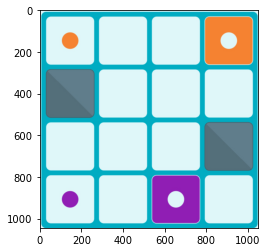

ImageLoader.ImageProcessed(size=4, blocked_locations=[(1, 0), (2, 3)], initial_locations=[(0, 3), (3, 2)], target_locations=[(0, 0), (3, 0)])

In [21]:
images = ImageLoader()
image = images[0]
plt.imshow(image.puzzle_image)
plt.show()
ImageLoader.parse_puzzle_image(image.puzzle_image, True)

In [27]:
levels = []
for idx in tqdm.trange(len(images)):
    image = images[idx]
    try:
        level = ImageLoader.parse_puzzle_image(image.puzzle_image, '_multi_' in image.name)
        levels.append(level)
    except AssertionError as e:
        plt.imshow(image.puzzle_image)
        print(image.name, "|", e)
        plt.show()

100%|██████████| 400/400 [00:09<00:00, 41.58it/s]
